## Data processing
### This file shows how to selected essential information in Integrated File.


## Part 1: Import Excel File 

In [1]:
import pandas as pd
import numpy as np

In [2]:
integrate_data=pd.read_excel('./DB_INTERGRATE_ENGLISH.xlsx')

In [15]:
integrate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20374 entries, 0 to 20373
Data columns (total 84 columns):
ID_CREDIT                      20374 non-null int64
COUNTRY                        20374 non-null object
ID_EVALUATION                  20374 non-null int64
NUMBER_OF_PAYMENTS             20374 non-null int64
REPORTED_PAYMENTS              20374 non-null int64
AMOUNT                         20374 non-null int64
MAXIMUM_CREDIT                 20374 non-null int64
CURRENT_BALANCE                20374 non-null int64
CREDIT_LIMIT                   20374 non-null int64
PENDING_BALANCE                20374 non-null int64
PAST_DUE_PAYMENTS              20374 non-null int64
WORST_PAST_DUE_BALANCE         20374 non-null int64
TIMES_PAST_DUE                 20374 non-null int64
OUTSTANDING_BALANCE            20374 non-null int64
AMOUNT_LAST_PAYMENT            20374 non-null int64
PLAZO_CREDITO_MESES            20374 non-null int64
AMOUNT_LOANED                  20374 non-null int64
GROUP_

## Distribution of Past Due Payments

In [19]:
pastduepayments=integrate_data[integrate_data['TYPE_OF_CUSTOMER2']=='PF'].PAST_DUE_PAYMENTS

In [25]:
pastduepayments.describe()

count    20299.000000
mean        13.626681
std         46.784986
min          0.000000
25%          0.000000
50%          0.000000
75%          5.000000
max        606.000000
Name: PAST_DUE_PAYMENTS, dtype: float64

(array([1.9355e+04, 3.1200e+02, 1.7600e+02, 1.1300e+02, 1.6400e+02,
        1.5700e+02, 1.6000e+01, 5.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0. ,  60.6, 121.2, 181.8, 242.4, 303. , 363.6, 424.2, 484.8,
        545.4, 606. ]),
 <a list of 10 Patch objects>)

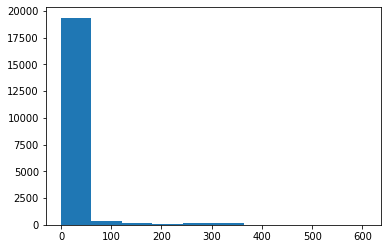

In [24]:
plt.hist(pastduepayments)

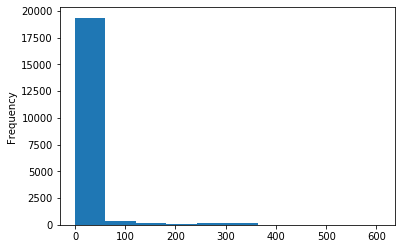

In [21]:
pastduepayments.plot.hist()

## Add good customers and Fraud customers to dataFrame
### Define good customers: past due payments = 0


In [9]:
def good_badcus(dataframe):
    good=[]
    fraud=[]
    for _, value in dataframe.items():
        if value==0:
            good.append(1)
            fraud.append(0)
        else:
            good.append(0)
            fraud.append(1)
    return good, fraud

In [16]:
good, fraud=good_badcus(integrate_data.PAST_DUE_PAYMENTS)
integrate_data.insert(0, "Good", good, True)
integrate_data.insert(1, "Fraud", fraud, True)

In [37]:
integrate_data.head()

,Good,Fraud,ID_CREDIT,COUNTRY,ID_EVALUATION,NUMBER_OF_PAYMENTS,REPORTED_PAYMENTS,AMOUNT,MAXIMUM_CREDIT,CURRENT_BALANCE,...,GENDER,MARITAL_STATUS,CPERSNUMCED,DEPENDENT_COUNT,DEATH_DATE,DATEOFREGISTRATION,IDCOUNTRY,COUNTY_DESC1,COUNTY_DESC2,STATE
0,1,0,9599,Mexico,276328,60,42,4605,111000,66604,...,NotSet,ND,NaN,0,NaN,29APR2009:00:00:00,MX,NaN,MINERAL DE LA REF,HGO
1,1,0,10143,Mexico,264533,60,18,4408,100000,91550,...,NotSet,ND,NaN,0,NaN,07AUG2009:00:00:00,MX,VILLA DE ALVAREZ,VILLA DE ALVAREZ,COL
2,1,0,19012,Mexico,172756,108,61,1599,57500,42648,...,NotSet,C,NaN,0,NaN,09JUN2014:00:00:00,MX,TIXTLA DE GUERRERO,TIXTLA DE GRO,GRO
3,0,1,12526,Mexico,150000,100,63,0,329595,0,...,NotSet,ND,NaN,0,NaN,01JAN2011:00:00:00,MX,ZAPOPAN,ZAPOPAN,JAL
4,1,0,12524,Mexico,0,12,7,0,10200,0,...,NotSet,ND,NaN,0,NaN,01JAN2011:00:00:00,MX,ZAPOPAN,ZAPOPAN,JAL


# Calculate total payments they need to pay since opening card
### 1. Build dataframe named data 
#### 1.1 TYPE_OF_CUSTOMER2, PAST_DUE_PAYMENTS, FREQUENCY_CODE, CREDIT_OPEN_DATE, DATE_CREDIT_UPDATE
#### 1.2 Calulate total days from opening card to update card
#### 1.3 Calulate total times they need to pay based on frequence payments

In [102]:
# Build dataframe contains type of customer, past due payments, frequency, credit opening, credit update
data=pd.DataFrame()
data.insert(0, "ID_CREDIT", integrate_data.ID_CREDIT, True)
data.insert(1, "TYPE_OF_CUSTOMER2", integrate_data.TYPE_OF_CUSTOMER2, True)
data.insert(2, "PAST_DUE_PAYMENTS", integrate_data.PAST_DUE_PAYMENTS, True)
data.insert(3, "FREQUENCY_CODE", integrate_data.FREQUENCY_CODE, True)
data.insert(4, "FREQUENCY_DESC", integrate_data.FREQUENCY_DESC, True)
data.insert(5, "CREDIT_OPEN_DATE", integrate_data.CREDIT_OPEN_DATE, True)
data.insert(6, "DATE_CREDIT_UPDATE", integrate_data.DATE_CREDIT_UPDATE, True)
date_cols = [col for col in data.columns if 'DATE' in col]
# Datetime formate
data[date_cols] = pd.to_datetime(data[date_cols].stack(),format="%d%b%Y:%H:%M:%S").unstack()
#Only keep person customer
data=data.loc[data['TYPE_OF_CUSTOMER2'] == 'PF']
data = data.drop(columns="TYPE_OF_CUSTOMER2")

In [103]:
# This function translate frequency code to datatime formate
# After run this function, the result is a list and contains unit corresponding to frequency
def translateunit(frequency):
    c=[]
    for _, value in frequency.items():
        if value=='M'or value=='R'or value=='U'or value=='D':
            c.append(np.timedelta64(1, 'M'))
        elif value=='Q'or value=='C':
            c.append(np.timedelta64(2, 'W'))
        elif value=='S':
            c.append(np.timedelta64(1, 'W'))
        elif value=='T':
            c.append(np.timedelta64(3, 'W'))
        elif value=='A':
            c.append(np.timedelta64(1, 'Y'))
        elif value=='B':
            c.append(np.timedelta64(2, 'M'))
    return c

In [104]:
# calculate total payment times
paymentimes=(data.DATE_CREDIT_UPDATE-data.CREDIT_OPEN_DATE)/translateunit(data.FREQUENCY_CODE)
# calculate whether total payment times > past due payments (True, False)
countgreater=paymentimes> data.PAST_DUE_PAYMENTS
# Add payments, countgreater to dataframe
data.insert(1, "Totoal_times", paymentimes, True)
data.insert(3, "Boolean", countgreater, True)
# Save data frame to execel name Data_related
data.to_excel("./Date_related.xlsx")

In [99]:
coun.value_counts()
data.FREQUENCY_CODE.value_counts()

## Build WOE Model based on Fraud data
$$WOE_i=-ln(\frac{P_{good}}{P_{fraud}})=-ln(\frac{G_i/G_{Total}}{F_i/F_{Total}}),\ i=1,2,...,N$$
### where G_i is the number of good samples in the i group of a variable, and G_Total is the sum of the number of good samples in all groups of a variable.

### F_i is the number of fraud samples in the ith group of a variable, and F_Total is the sum of the number of fraud samples in all groups of a variable.


## Build IV Model based on Fraud data and WOE 
### The information of the i-th group of a variable
$$IV_i=(P_{fraud}-P_{good})*WOE_i,\ i=1,2,...,N$$

### Total information for a variable
$$IV=\sum IV_i,\ i=1,2,...,N$$



In [50]:
def woewoe(b):
    b["fraud_ratio"]=b.iloc[:,1]/(b.iloc[:,0]+b.iloc[:,1]) 
    b["Total_amount"]=(b.iloc[:,0]+b.iloc[:,1])    
    b["fraud_occupancy"]=b.iloc[:,1]/b.iloc[:,1].sum()
    b["good_occupancy"]=b.iloc[:,0]/b.iloc[:,0].sum()
    b["WOE"]=np.log((b["good_occupancy"]/b["fraud_occupancy"]))*(-1)
    b["bin_IV"]=b["WOE"]*(b["fraud_occupancy"]-b["good_occupancy"])
    b["IV"]=b["bin_IV"].sum()
    return b

In [39]:
# Build dataframe contains type of customer, past due payments, state, zipcode
dataregion=pd.DataFrame()
dataregion.insert(0, "ID_CREDIT", integrate_data.ID_CREDIT, True)
dataregion.insert(1, "Good", integrate_data.Good, True)
dataregion.insert(2, "Fraud", integrate_data.Fraud, True)
dataregion.insert(1, "TYPE_OF_CUSTOMER2", integrate_data.TYPE_OF_CUSTOMER2, True)
dataregion.insert(3, "ZIPCODE", integrate_data.ZIPCODE, True)
dataregion.insert(4, "STATE", integrate_data.STATE, True)
#Only keep person customer
dataregion=dataregion.loc[dataregion['TYPE_OF_CUSTOMER2'] == 'PF']
dataregion = dataregion.drop(columns="TYPE_OF_CUSTOMER2")
dataregion_good=dataregion.loc[dataregion['Good'] == 1]
dataregion_fraud=dataregion.loc[dataregion['Fraud'] == 1]

In [45]:
f=dataregion_fraud.groupby('STATE')['Fraud'].count()
g=dataregion_good.groupby('STATE')['Good'].count()

In [47]:
frame=pd.DataFrame()
frame.insert(0, "Good", g, True)
frame.insert(1, "Fraud", f, True)

In [51]:
woewoe(frame)

,Good,Fraud,fraud_ratio,Total_amount,fraud_occupancy,good_occupancy,WOE,bin_IV,IV
STATE,,,,,,,,,
AGS,53,35,0.397727,88,0.004317,0.004347,-0.006892,2.057609e-07,0.078166
BC,245,77,0.239130,322,0.009498,0.020095,-0.749401,7.941534e-03,0.078166
BCS,72,46,0.389831,118,0.005674,0.005906,-0.039973,9.249782e-06,0.078166
CAMP,550,121,0.180328,671,0.014925,0.045112,-1.106076,3.338819e-02,0.078166
CDMX,18,27,0.600000,45,0.003330,0.001476,0.813517,1.508324e-03,0.078166
CHIH,159,87,0.353659,246,0.010731,0.013041,-0.194944,4.502956e-04,0.078166
CHIS,218,223,0.505669,441,0.027507,0.017881,0.430729,4.146418e-03,0.078166
COAH,301,210,0.410959,511,0.025904,0.024688,0.048049,5.839056e-05,0.078166
COL,8,16,0.666667,24,0.001974,0.000656,1.101199,1.450759e-03,0.078166


# Find Relation between Past Due Payment and Region
## Plot scatter find any relation between state, zipcode, pastdue

In [3]:
# Build dataframe contains type of customer, past due payments, state, zipcode
dataregion=pd.DataFrame()
dataregion.insert(0, "ID_CREDIT", integrate_data.ID_CREDIT, True)
dataregion.insert(1, "TYPE_OF_CUSTOMER2", integrate_data.TYPE_OF_CUSTOMER2, True)
dataregion.insert(2, "PAST_DUE_PAYMENTS", integrate_data.PAST_DUE_PAYMENTS, True)
dataregion.insert(3, "ZIPCODE", integrate_data.ZIPCODE, True)
dataregion.insert(4, "STATE", integrate_data.STATE, True)
#Only keep person customer
dataregion=dataregion.loc[dataregion['TYPE_OF_CUSTOMER2'] == 'PF']
dataregion = dataregion.drop(columns="TYPE_OF_CUSTOMER2")

In [88]:
DF.groupby('ZIPCODE')['PAST_DUE_PAYMENTS'].describe()

,count,mean,std,min,25%,50%,75%,max
ZIPCODE,,,,,,,,
1140,13.0,83.615385,101.002094,0.0,2.00,46.0,139.00,355.0
1210,18.0,9.388889,13.890915,0.0,0.25,1.5,9.50,38.0
1219,22.0,23.227273,58.098383,0.0,0.50,4.0,10.25,209.0
1296,11.0,71.545455,122.542534,0.0,0.00,0.0,129.50,264.0
1298,57.0,6.122807,11.178855,0.0,0.00,1.0,7.00,54.0
1650,6.0,35.833333,33.259084,1.0,6.00,38.5,65.00,68.0
1860,4.0,88.750000,172.176992,0.0,3.00,4.0,89.75,347.0
2050,4.0,22.500000,30.182777,0.0,1.50,12.5,33.50,65.0
2060,32.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [4]:
statedate=dataregion.groupby('STATE')['PAST_DUE_PAYMENTS'].describe().sort_values('mean')
import matplotlib.pyplot as plt

In [5]:
statedate

,count,mean,std,min,25%,50%,75%,max
STATE,,,,,,,,
ZAC,20.0,1.450000,3.410124,0.0,0.0,0.0,1.00,14.0
YUC,329.0,5.939210,23.273610,0.0,0.0,0.0,2.00,348.0
CAMP,671.0,7.099851,35.969894,0.0,0.0,0.0,0.00,347.0
HGO,947.0,9.026399,34.262701,0.0,0.0,0.0,2.00,425.0
NL,597.0,9.386935,34.280956,0.0,0.0,0.0,4.00,347.0
TAB,292.0,9.431507,38.629513,0.0,0.0,0.0,3.00,335.0
GRO,1185.0,9.858228,42.873185,0.0,0.0,0.0,2.00,466.0
GTO,674.0,10.747774,39.997086,0.0,0.0,0.0,4.00,331.0
OAX,809.0,11.077874,38.223226,0.0,0.0,0.0,6.00,371.0


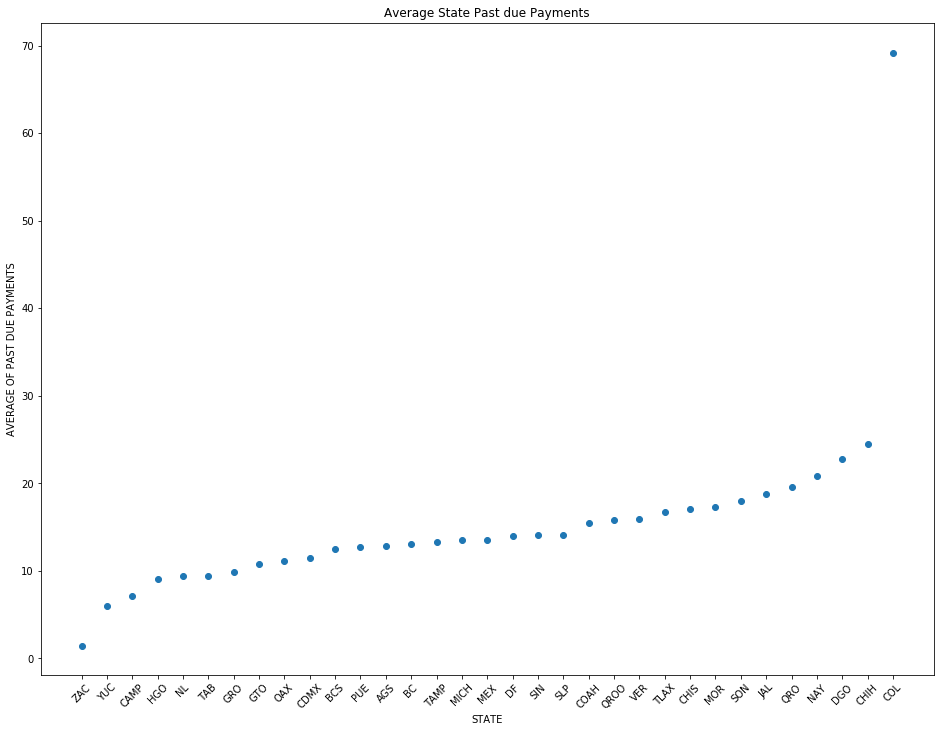

In [15]:
plt.figure(figsize=(16, 12))
plt.scatter(statedate.index, statedate['mean'])
plt.title('Average State Past due Payments')
plt.xlabel('STATE')
plt.ylabel('AVERAGE OF PAST DUE PAYMENTS')
plt.xticks(rotation=45)
plt.show()

#### From above Figure, we can see STATE ZAC has lowest average past payments, STATE COL has highest average past payments.
#### ZAC only contains 20 customes,  COL only contains 24 customes, due to lack of customes, we could analyze these two states later.

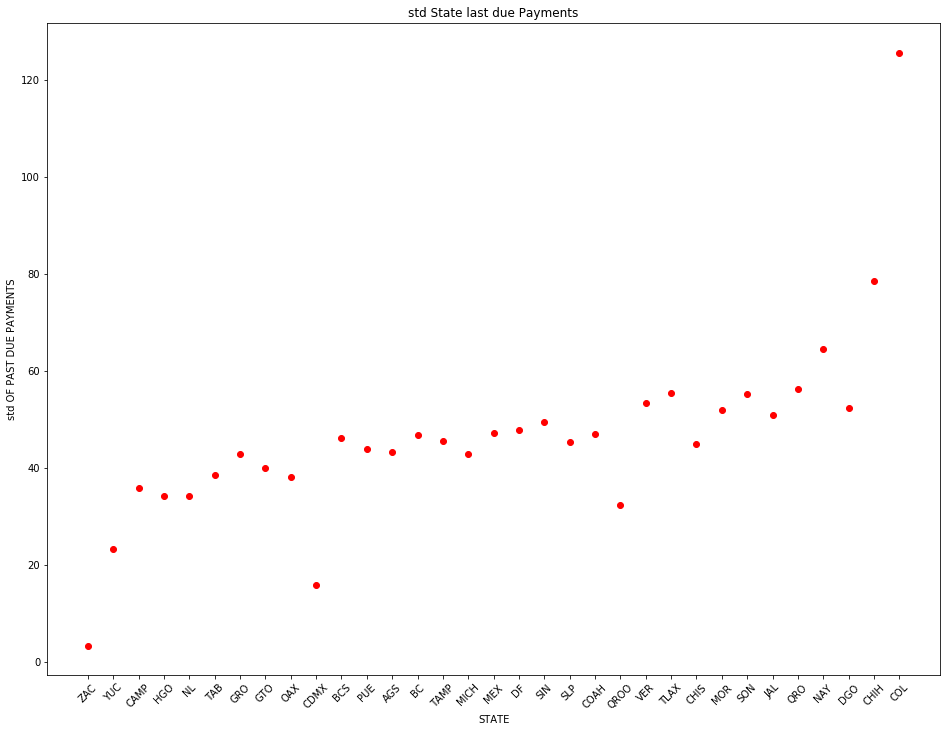

In [18]:
plt.figure(figsize=(16, 12))
plt.scatter(statedate.index, statedate['std'],color='red')
plt.title('std State last due Payments')
plt.xlabel('STATE')
plt.ylabel('std OF PAST DUE PAYMENTS')
plt.xticks(rotation=45)
plt.show()

In [8]:
len(statedate.mean())

8

In [71]:
dataregion.ZIPCODE.value_counts()


24350    479
89344    336
92736    257
40900    243
48340    217
86029    176
54424    154
22204    154
42180    153
69800    151
42651    138
40000    137
96345    130
95830    130
72760    126
76220    121
5600     119
45640    118
74730    116
60950    114
95450    108
68313    101
13120     97
73700     94
60954     92
56395     89
79000     87
81294     84
93230     83
96344     81
        ... 
67500      2
71700      2
22790      2
40010      2
6400       2
7210       2
45595      2
75670      2
89106      2
7320       2
21250      1
66635      1
81140      1
79770      1
6920       1
51760      1
42990      1
27942      1
50582      1
38095      1
9225       1
58116      1
63700      1
82700      1
27275      1
88289      1
72490      1
15600      1
15850      1
29370      1
Name: ZIPCODE, Length: 862, dtype: int64

In [69]:
dataregion.STATE

0         HGO
1         COL
2         GRO
3         JAL
4         JAL
5          DF
6         COL
7          DF
8          DF
9        TLAX
10         DF
11        VER
12        VER
13        MEX
14        VER
15         DF
16        OAX
17        VER
18        MEX
19        OAX
20        MEX
21         DF
22        GRO
23        MEX
24        VER
25        VER
26        VER
27         DF
28        MEX
29        OAX
         ... 
20344     GRO
20345     GRO
20346     GRO
20347     GRO
20348    CHIS
20349    CHIS
20350      DF
20351      DF
20352      DF
20353      DF
20354      DF
20355      DF
20356      DF
20357      DF
20358      DF
20359      NL
20360      NL
20361      NL
20362      NL
20363    MICH
20364      DF
20365     MEX
20366     MEX
20367     MEX
20368     MEX
20369     MEX
20370    QROO
20371    TAMP
20372    QROO
20373    TAMP
Name: STATE, Length: 20299, dtype: object

In [10]:
integrate_data.head(5)

,ID_CREDIT,COUNTRY,ID_EVALUATION,NUMBER_OF_PAYMENTS,REPORTED_PAYMENTS,AMOUNT,MAXIMUM_CREDIT,CURRENT_BALANCE,CREDIT_LIMIT,PENDING_BALANCE,...,GENDER,MARITAL_STATUS,CPERSNUMCED,DEPENDENT_COUNT,DEATH_DATE,DATEOFREGISTRATION,IDCOUNTRY,COUNTY_DESC1,COUNTY_DESC2,STATE
0,9599,Mexico,276328,60,42,4605,111000,66604,111000,0,...,NotSet,ND,NaN,0,NaN,29APR2009:00:00:00,MX,NaN,MINERAL DE LA REF,HGO
1,10143,Mexico,264533,60,18,4408,100000,91550,100000,0,...,NotSet,ND,NaN,0,NaN,07AUG2009:00:00:00,MX,VILLA DE ALVAREZ,VILLA DE ALVAREZ,COL
2,19012,Mexico,172756,108,61,1599,57500,42648,57500,0,...,NotSet,C,NaN,0,NaN,09JUN2014:00:00:00,MX,TIXTLA DE GUERRERO,TIXTLA DE GRO,GRO
3,12526,Mexico,150000,100,63,0,329595,0,0,0,...,NotSet,ND,NaN,0,NaN,01JAN2011:00:00:00,MX,ZAPOPAN,ZAPOPAN,JAL
4,12524,Mexico,0,12,7,0,10200,0,10200,0,...,NotSet,ND,NaN,0,NaN,01JAN2011:00:00:00,MX,ZAPOPAN,ZAPOPAN,JAL


In [3]:
integrate_data=integrate_data.drop(['DATE_LAST_ZERO', 'UPDATE_TYPE','ID_CREDIT_UPDATE','DEATH_DATE'], axis=1)
date_cols = [col for col in integrate_data.columns if 'DATE' in col]
integrate_data[date_cols] = pd.to_datetime(integrate_data[date_cols].stack(),format="%d%b%Y:%H:%M:%S").unstack()
integrate_data[date_cols].head()

,CREDIT_OPEN_DATE,LAST_PAYMENT_DATE,LAST_PURCHASE_DATE,MAX_LIQUIDITY_DATE,RENEGOTIATED_DATE,CREDIT_PROCESSING_DATE,REGISTRATION_DATE,CUTOFF_DATE,REGISTRATION_DATE.1,DATE_CREDIT_UPDATE,DATE_WORST_DELAY,DATE_REGISTERED_AS_PAST_DUE,DATEOFBIRTH,DATEOFREGISTRATION
0,2016-07-07,2019-11-14,2016-07-07,NaT,2019-12-06,2019-12-06,2016-08-11,2019-11-30,2016-08-11 21:45:46,2019-12-06 09:27:58,NaT,NaT,1960-08-28,2009-04-29
1,2018-06-14,2019-11-14,2018-06-14,NaT,2019-12-06,2019-12-06,2018-07-03,2019-11-30,2018-07-03 13:39:59,2019-12-06 09:27:49,NaT,NaT,1964-07-09,2009-08-07
2,2017-03-21,2019-12-04,2017-03-21,NaT,2019-12-18,2019-12-18,2017-05-22,2019-12-15,2017-05-22 05:01:00,2019-12-18 11:11:32,NaT,NaT,1989-12-07,2014-06-09
3,2014-05-04,2015-07-07,2014-05-04,2015-07-07,2015-07-13,2015-07-13,2014-05-07,2015-07-08,2014-05-07 20:57:00,2015-07-13 07:29:46,2015-07-05,NaT,1981-02-09,2011-01-01
4,2005-12-08,2007-11-21,2005-12-08,2007-11-21,2011-05-18,2011-05-18,2011-05-18,2011-03-31,2011-01-01 01:21:13,2011-05-18 06:34:46,NaT,NaT,1981-02-09,2011-01-01


In [5]:
data=integrate_data[date_cols]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20374 entries, 0 to 20373
Data columns (total 14 columns):
CREDIT_OPEN_DATE               20374 non-null datetime64[ns]
LAST_PAYMENT_DATE              19968 non-null datetime64[ns]
LAST_PURCHASE_DATE             20224 non-null datetime64[ns]
MAX_LIQUIDITY_DATE             15823 non-null datetime64[ns]
RENEGOTIATED_DATE              20070 non-null datetime64[ns]
CREDIT_PROCESSING_DATE         20374 non-null datetime64[ns]
REGISTRATION_DATE              20374 non-null datetime64[ns]
CUTOFF_DATE                    20374 non-null datetime64[ns]
REGISTRATION_DATE.1            20374 non-null datetime64[ns]
DATE_CREDIT_UPDATE             20374 non-null datetime64[ns]
DATE_WORST_DELAY               8179 non-null datetime64[ns]
DATE_REGISTERED_AS_PAST_DUE    255 non-null datetime64[ns]
DATEOFBIRTH                    20374 non-null datetime64[ns]
DATEOFREGISTRATION             20374 non-null datetime64[ns]
dtypes: datetime64[ns](14)
memory usage: